Цель  - релизовать методом  SVC, c учетом нелинейных ядер


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit

from sklearn.svm import SVC
from sklearn.metrics import auc, roc_auc_score

## Анализ данных

In [2]:
data = pd.read_csv('./data/winequality-red.csv', sep=';')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
data.columns = data.columns.str.replace(' ', '_')

In [4]:
data.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [5]:
data.isnull().sum()

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Датасет не содердит пропусков! 

Датасет содержит следующие данные: 
   
**fixed acidity**  - фиксированная кислотность. Большинство кислот, связанных с вином, либо фиксированные, либо нелетучие (легко не испаряются).

**volatile_acidity**  - летучая кислотность. Количество уксусной кислоты в вине, слишком высокое содержание которой может привести к неприятному вкусу уксуса.

**citric_acid**  - лимонная кислота; в небольших количествах лимонная кислота может придать вину «свежесть» и аромат.

**residual_sugar**  - остаточный сахар: количество сахара, оставшееся после остановки брожения, вина с содержанием сахара менее 1 грамма на литр встречаются редко, а вина с содержанием сахара более 45 граммов на литр считаются сладкими

**chlorides**  - хлориды; количество соли в вине. 

**free_sulfur_dioxide**  - свободный диоксид серы: свободная форма SO2 существует в равновесии между молекулярным SO2 (в виде растворенного газа) и бисульфит-ионом; он предотвращает рост микробов и окисление вина. 

**total_sulfur_dioxide**  - диоксид серы общий; количество свободной и связанной форм SO2; при низких концентрациях SO2 практически не обнаруживается в вине, но при концентрациях свободного SO2 более 50 частей на миллион SO2 становится заметным в аромате и вкусе вина. 

**density**  -плотность; плотность вина близка к плотности воды в зависимости от процентного содержания алкоголя и сахара. 

**pH**  - плотность; описывает, насколько кислым или щелочным является вино по шкале от 0 (очень кислое) до 14 (очень щелочное).

**sulphates**  - сульфаты; добавка к вину, которая может повышать уровень сернистого газа (SO2), действует как противомикробное средство и антиоксидант 

**alcohol**  - алкоголь; процент содержания алкоголя в вине.

**quality**  - качество; целевая переменная

## Анализ данных
Для каждого признака построим его распределение
Распределение построим как с помощью функции graphdistrib так и с помощью библиотеки seaborn

#### fixed_acidity

In [6]:
def graphdistrib(data, column, band = 0.3):
    X = data[column].values
    X = X.reshape(-1, 1)

    kde = KernelDensity(kernel='gaussian', bandwidth=band).fit(X)
    parcelDensity = kde.score_samples(X)

    X = X.reshape(1, -1)[0]
    Y = np.exp(parcelDensity.reshape(1, -1)[0])

    fig, ax = plt.subplots(figsize=(8, 6))
    plt.bar(X, Y)
    plt.title('Optimal estimate feature ' + column +  ' with Gaussian kernel')
    plt.show()


def graphdistribSns(data,column ):
    sns.kdeplot(data=data, x=column)

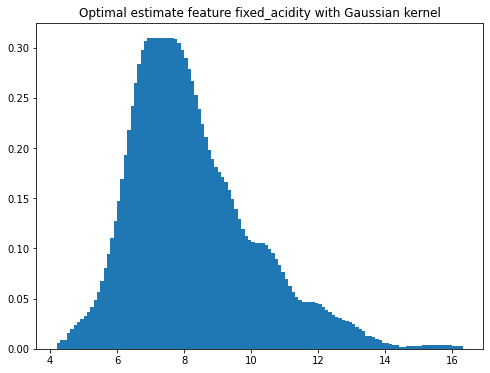

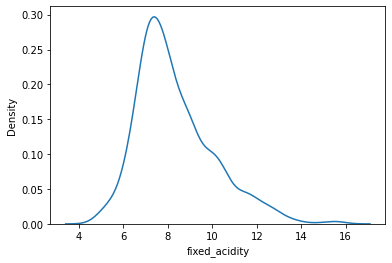

In [35]:
graphdistrib(data, 'fixed_acidity' )
graphdistribSns(data, 'fixed_acidity')

#### volatile_acidity

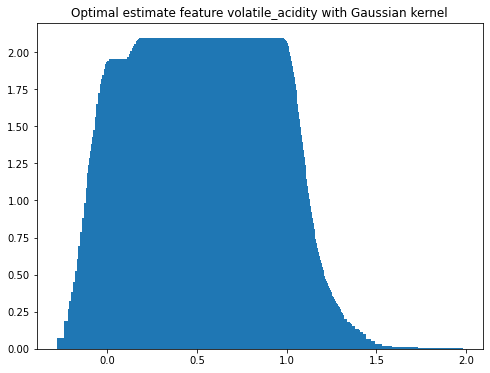

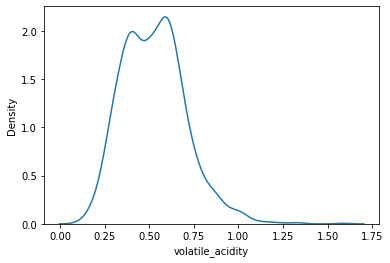

In [37]:
graphdistrib(data, 'volatile_acidity', 0.05 )
graphdistribSns(data, 'volatile_acidity')

#### citric_acid

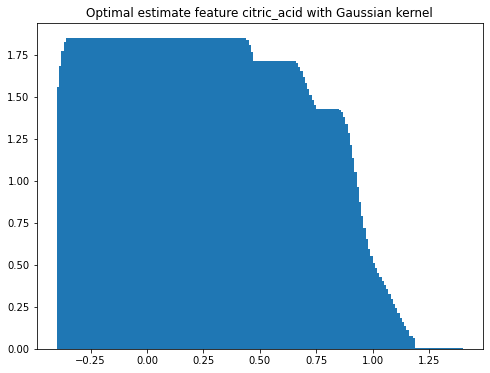

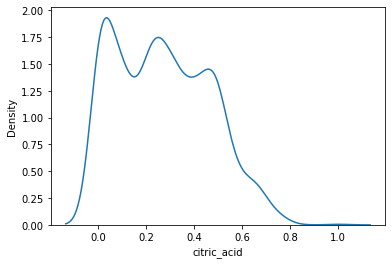

In [45]:
graphdistrib(data, 'citric_acid', 0.05 )
graphdistribSns(data, 'citric_acid')

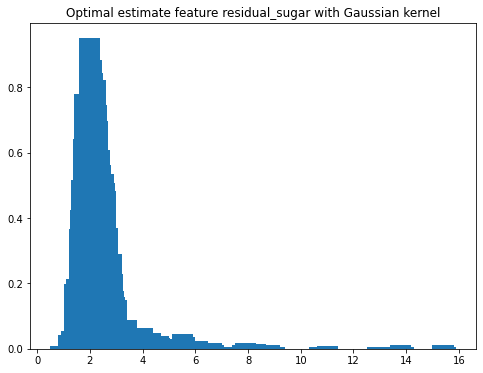

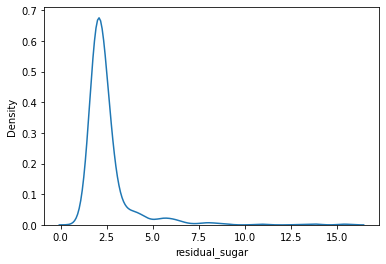

In [46]:
## residual_sugar
graphdistrib(data, 'residual_sugar', 0.05 )
graphdistribSns(data, 'residual_sugar')

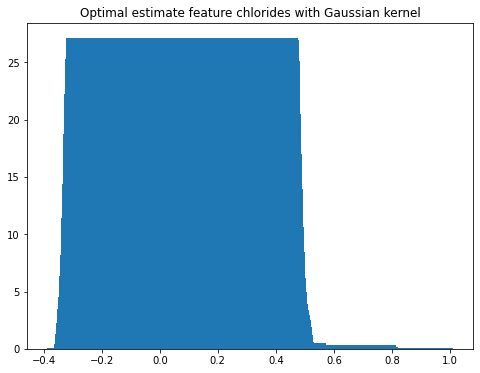

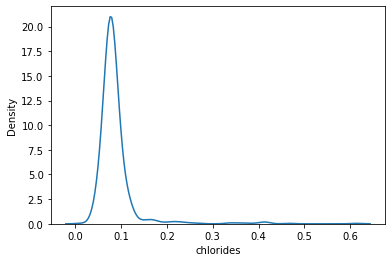

In [48]:
## chlorides
graphdistrib(data, 'chlorides', 0.005 )
graphdistribSns(data, 'chlorides')

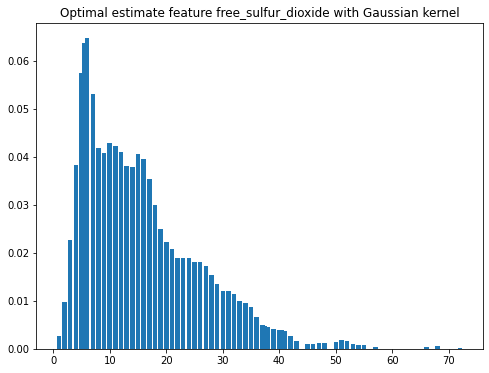

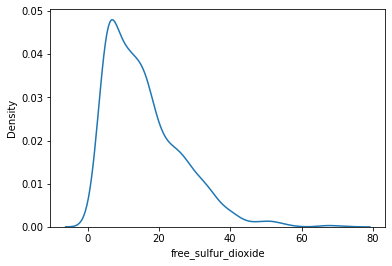

In [52]:
## free_sulfur_dioxide
graphdistrib(data, 'free_sulfur_dioxide', 1 )
graphdistribSns(data, 'free_sulfur_dioxide')

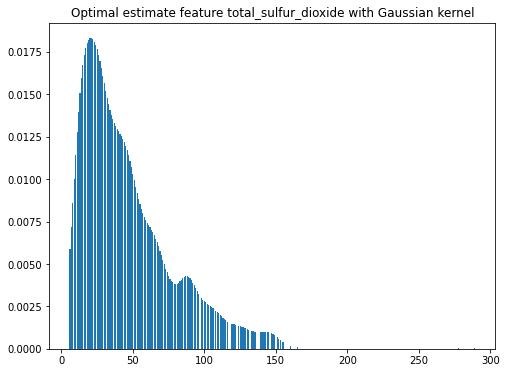

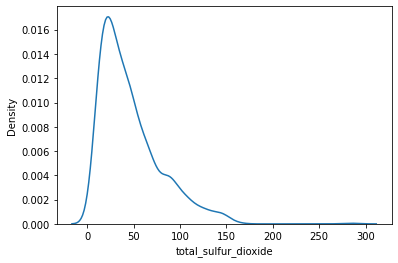

In [54]:
## total_sulfur_dioxide
graphdistrib(data, 'total_sulfur_dioxide', 5 )
graphdistribSns(data, 'total_sulfur_dioxide')

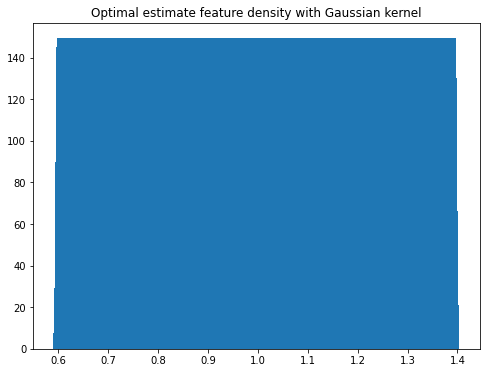

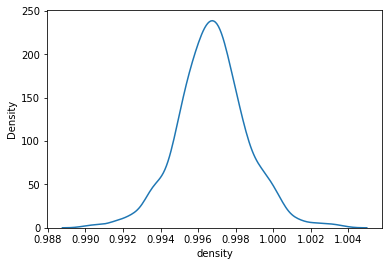

In [63]:
## density
graphdistrib(data, 'density', 0.002 )
graphdistribSns(data, 'density')

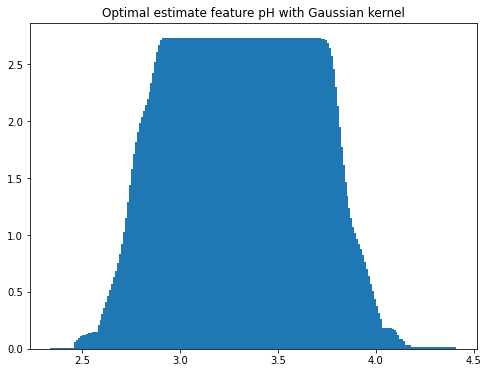

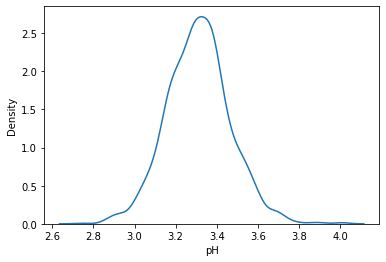

In [66]:
## pH
graphdistrib(data, 'pH', 0.03 )
graphdistribSns(data, 'pH')

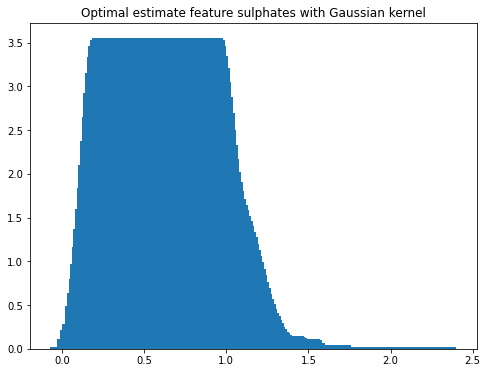

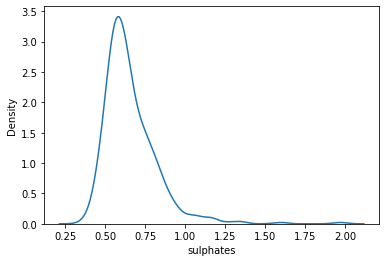

In [67]:
## sulphates
graphdistrib(data, 'sulphates', 0.03 )
graphdistribSns(data, 'sulphates')

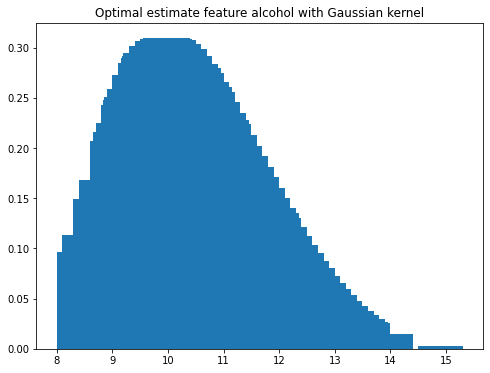

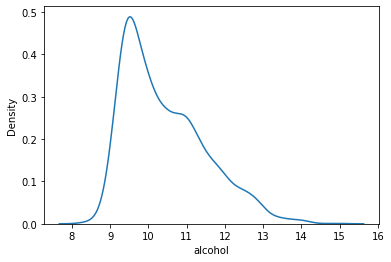

In [71]:
## alcohol
graphdistrib(data, 'alcohol', 0.8)
graphdistribSns(data, 'alcohol')

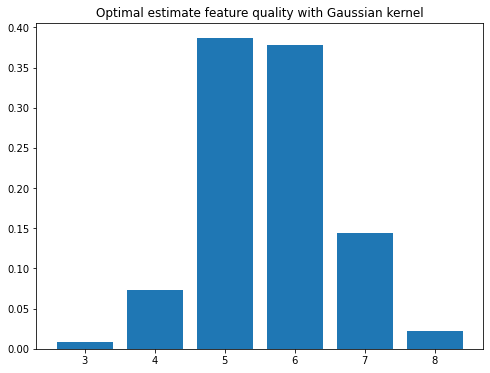

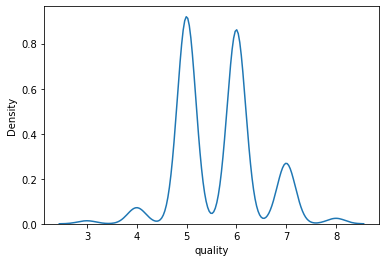

In [73]:
## quality
graphdistrib(data, 'quality', 0.5)
graphdistribSns(data, 'quality')

# Преобразование данных и поиск оптимальной модели


In [7]:
data['target'] =  data.apply(
            lambda row: 0 if (row['quality'] < 6.5)
            else 1, axis=1)

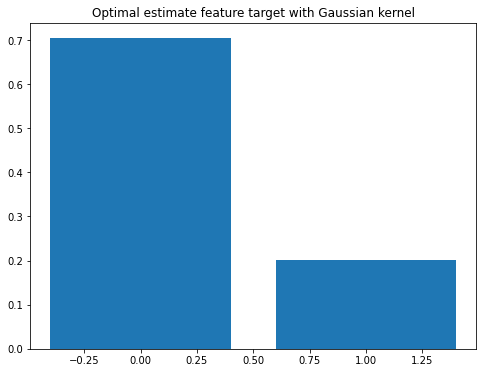

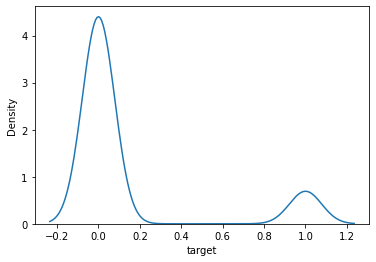

In [8]:
## quality
graphdistrib(data, 'target', 0.5)
graphdistribSns(data, 'target')

In [11]:
Y_n= data['target'].copy()

scaler = StandardScaler()
X = data.drop(['target', 'quality'], axis=1).copy()
X_n = scaler.fit_transform(X)

In [12]:
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': np.logspace(-1, 3, num=10),
    'gamma': np.linspace(0.001, 1, num=10),
}
model = SVC()
cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, train_size=0.8, random_state=45)
clf = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy',cv=cv,n_jobs=-1)
clf.fit(X_n, Y_n)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=45, test_size=0.2,
            train_size=0.8),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-01, 2.78255940e-01, 7.74263683e-01, 2.15443469e+00,
       5.99484250e+00, 1.66810054e+01, 4.64158883e+01, 1.29154967e+02,
       3.59381366e+02, 1.00000000e+03]),
                         'gamma': array([0.001, 0.112, 0.223, 0.334, 0.445, 0.556, 0.667, 0.778, 0.889,
       1.   ]),
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy')

In [13]:
clf.best_params_

{'C': 2.1544346900318834, 'gamma': 0.667, 'kernel': 'rbf'}

In [14]:
clf.best_score_

0.9208333333333334

# Нахождение кросвалидации модели

In [16]:
Y_n= data['target'].copy()
X = data.drop(['target', 'quality'], axis=1).copy()

scaler = StandardScaler()
X_n = scaler.fit_transform(X)

In [17]:
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, train_test_split, cross_val_score, cross_validate

model_test = SVC(kernel='rbf', C=2.1544,gamma=0.667, probability=True)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, train_size=0.8, random_state=45)

scores = cross_val_score(model_test, X_n, Y_n, cv=cv, scoring='accuracy')

In [18]:
scores.mean()

0.9125

### Нахождение confusion matrix и roc_auc_score 

In [19]:
from sklearn.metrics import confusion_matrix,  accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
def confusion_matrix_scorer(clf, X, y):
    y_pred = clf.predict(X)
    y_pred_probs = clf.predict_proba(X)

    roc = roc_auc_score(y, y_pred_probs[:, 1])
    cm = confusion_matrix(y, y_pred)

    return {
        'tn': cm[0, 0],
        'tn': cm[0, 0],
        'fp': cm[0, 1],
        'fn': cm[1, 0],
        'tp': cm[1, 1],
        'roc': roc
    }
cv_results = cross_validate(model_test, X_n, Y_n, cv=cv, scoring=confusion_matrix_scorer)

In [20]:
cv_results

{'fit_time': array([0.29699922, 0.29302979, 0.28403354, 0.28900409, 0.28802991]),
 'score_time': array([0.0430274 , 0.04299712, 0.04199624, 0.04297113, 0.04199576]),
 'test_tn': array([271, 272, 272, 269, 263]),
 'test_fp': array([ 6,  5,  5,  8, 14]),
 'test_fn': array([17, 19, 24, 22, 20]),
 'test_tp': array([26, 24, 19, 21, 23]),
 'test_roc': array([0.85164974, 0.93686508, 0.82016623, 0.88909411, 0.90042818])}

In [21]:
cv_results['test_roc'].mean()

0.879640668289816

## Нахождение оптимального количества признаков
Для этого попрбуем воспользоватся 
 - введем полиноминальные свойства
 - выберем из признаков 5 наиболее важных SelectKBest и сравним полученную модель 
 

In [71]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif

Y_n= data['target'].copy()
X = data.drop(['target', 'quality'], axis=1).copy()

scaler = StandardScaler()
X_n = scaler.fit_transform(X)


col = list(data.columns)
col.remove('target')
col.remove('quality')
x_data = pd.DataFrame(data=X_n, columns=col )


trans = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
paramsTransform = trans.fit_transform(x_data)
paramsPoly = pd.DataFrame(data=paramsTransform, columns=trans.get_feature_names(x_data.columns))

fs = SelectKBest(score_func=f_classif, k=5)
X_selected = fs.fit_transform(paramsPoly, Y_n)
cols = fs.get_support(indices=True)

features_df_new = paramsPoly.iloc[:,cols]


scalerNew = StandardScaler()
df_new = scalerNew.fit_transform(features_df_new)

c:\study\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [72]:
model_test = SVC(kernel='rbf', C=2.1544,gamma=0.667, probability=True)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, train_size=0.8, random_state=45)

scores = cross_val_score(model_test, df_new, Y_n, cv=cv, scoring='accuracy')


In [73]:
scores.mean()

0.8706250000000001

Вывод:
 - распределение параметров похожи на нормальное или биноминальное распределение
 - целевая переменная приведена 0 (плохое вино) или 1 (хорошее)
 - признаки масштаброваны
 - произведен поиск оптимальных параметров алгоритма SVC 
 
К сожалениею введение полиноминальных признаков не привел к улучшению точности классификации (0.87 против 0.9125). На мой взгляд нужно вводить какие то еще параметры извне. C сдругой стороны оставшие 5 признаков обеспечивают неплохой результат - были сокращены данные

У  датасета перекос в значениях плохих вин (70%), простое дублирование хороших вин не поправит ситуатцию (выравнение датасата по количество целевого параметра) 


PSS Будет классно если проверябщий напишет в замечаниях идеи!